In [ ]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import hadamard
import scipy.io as io
import scipy.special as sc
from scipy.stats import ortho_group
import os

In [ ]:
def DJW(X, eps):

	(d, n) = X.shape
  # Using {d \choose d/2} approximation
	B = (math.exp(eps)+1)/(math.exp(eps)-1)*np.sqrt(math.pi*d/2)
	pi_a = math.exp(eps)/(1+math.exp(eps))
	X_perturb = X.copy()
	
	for i in range(n):
		# only handle when X[:, i] is a unit vector
		v = np.random.normal(0, 1, size = d)
		v = v/np.linalg.norm(v, 2) # v uniform over l_2 unit ball
		if np.sum(v * X[:, i]) < 0:
			v = -v

		T = 2*np.random.binomial(1, pi_a)-1
		X_perturb[:, i] = T*v
		
	return [X_perturb, B]

In [ ]:
def find_best_gamma(X, eps):
  (d, n) = X.shape
  gamma = (math.exp(eps)-1)/(math.exp(eps)+1)*np.sqrt(math.pi/(2*d-2))
  g_2 = min(math.exp(eps)/(6*math.sqrt(d)),0.999)
  while eps < 1/2*math.log(d*36)-(d-1)/2*math.log(1-g_2**2)+math.log(g_2):
    g_2 = g_2/1.01
  if g_2 > math.sqrt(2/d):
    gamma = max(g_2, gamma)
  return gamma

def privUnit(X, p, gamma):
  (d, n) = X.shape
  alpha = (d-1)/2
  tau = (1+gamma)/2
  m = (d-2)/(d-1)*(1-gamma**2)**alpha/(2*np.sqrt(math.pi*(d-3)/2))*(p/(1-sc.betainc(alpha, alpha, tau))-(1-p)/sc.betainc(alpha, alpha, tau))
  X_perturb = X.copy()

  for i in range(n):
		# only handle when X[:, i] is a unit vector
    while True:
        v = np.random.normal(0, 1, size = d)
        v = v/np.linalg.norm(v, 2) # v uniform over l_2 unit ball
        if np.abs(np.sum(v * X[:, i])) > gamma:
            break
    if np.sum(v * X[:, i]) < 0:
        v = -v
    T = 2*np.random.binomial(1, p)-1
    X_perturb[:, i] = T*v
  return [X_perturb, 1/m]

In [ ]:
def Kashin_representation(x, U, eta = 0.4, delta = 0.8):
	# compute kashin representation of x with respect to the frame U at level K
	# U = [u_1, u_2, ..., u_N]^T
	(N, d) = U.shape
	a = np.zeros((N, 1))

	K = 1/((1-eta)*np.sqrt(delta)) # Set Kashin level to be K
	M = eta/np.sqrt(delta*N)

	y = x
	itr = int(np.log(N))
	for i in range(itr):
		b = U @ y
		b_hat = np.clip(b, -M, M)
		y = y - U.T @ b_hat
		a = a + b_hat
		M = eta*M

	b = U @ y
	Ty = U.T @ b
	y = y - Ty
	a = a + b
	return [a, K/np.sqrt(N)]

def rand_quantize(a, a_bdd):
	return (np.random.binomial(1, (np.clip(a, -a_bdd, a_bdd)+a_bdd)/(2*a_bdd))-1/2)*2*a_bdd

def rand_sampling(q, k):
	# each column of q represents a quantized observation with Kashin representation
	# output k sampling matrices and an aggregation of q*sampling_mat
	(N, n) = q.shape
	sampling_mat_sum = np.zeros((n, N))
	sampling_mat_list = []
	for i in range(k):
		spl = np.eye(N)[np.random.choice(N, n)]
		sampling_mat_sum = sampling_mat_sum + spl 
		sampling_mat_list.append(spl.T)

	return [sampling_mat_list, sampling_mat_sum.T, q * sampling_mat_sum.T/k]

def kRR(k, eps, q_sampling, sampling_mat_list, a_bdd):
	# perturb each column of q, as a k-bit string, via k-RR mechanism 
	q_perturb = q_sampling.copy()
	(N, n) = q_sampling.shape
	for j in range(n):
		if (np.random.uniform(0,1) > (math.exp(eps)-1)/(math.exp(eps)+2**k-1)):
			noise = np.zeros(N)
			for i in range(k):
				# create a random {-1, +1}^N vector and filter it by sampling matrices
				noise = noise + (2*np.random.binomial(1, 1/2*np.ones(N))-1)*sampling_mat_list[i][:, j].reshape(-1,)/k

			q_perturb[:, j] = noise*a_bdd
	return q_perturb

def estimate(k, eps, q_perturb):
	return	(math.exp(eps)+2**k-1)/(math.exp(eps)-1)*q_perturb 

def kRR_string(d, num, eps):
	if (np.random.uniform(0,1) < math.exp(eps)/(math.exp(eps)+d-1)):
		return num
	else:
		return np.radom.choice(d)

def Kashin_encode(U, X, k, eps):
	[a, a_bdd] = Kashin_representation(X, U)
	q = rand_quantize(a, a_bdd)
	[sampling_mat_list, sampling_mat_sum, q_sampling] =  rand_sampling(q, k)
	q_perturb = kRR(k, eps, q_sampling, sampling_mat_list, a_bdd)
	return [q, q_sampling, q_perturb]

def Kashin_decode(U, k, eps, q_perturb):
	(N, d) = U.shape
	q_unbiased = estimate(k, eps, q_perturb)
	return U.T @ (np.mean(q_unbiased*N, axis = 1)).reshape(-1, 1)

def DJW_encode(U, X, k, eps):
	[X_perturb, B] = DJW(X, eps)
	[a, a_bdd] = Kashin_representation(X_perturb, U)
	q = rand_quantize(a, a_bdd)
	[sampling_mat_list, sampling_mat_sum, q_sampling] =  rand_sampling(q, k)
	return [a, q, q_sampling, B]

def DJW_decode(U, k, eps, q_sampling, B):
	(N, d) = U.shape
	return B*U.T @ (np.mean(q_sampling*N, axis = 1)).reshape(-1,1)

d = 200
eps = 10
--------------
n = 10000
Kashin mse: 0.008301
DJW mse: 0.032517
reDJW mse: 0.014452
priUnit mse: 0.009050
--------------
n = 14000
Kashin mse: 0.006212
DJW mse: 0.022062
reDJW mse: 0.010641
priUnit mse: 0.006238
--------------
n = 18000
Kashin mse: 0.004886
DJW mse: 0.017161
reDJW mse: 0.008135
priUnit mse: 0.004949
--------------
n = 22000
Kashin mse: 0.003889
DJW mse: 0.012904
reDJW mse: 0.006942
priUnit mse: 0.003820
--------------
n = 26000
Kashin mse: 0.003470
DJW mse: 0.011863
reDJW mse: 0.005749
priUnit mse: 0.003452
--------------
Kashin mse:
[0.00830114 0.00621179 0.00488618 0.00388923 0.00347007]
DJW mse:
[0.03251673 0.02206234 0.01716146 0.01290439 0.01186293]
reDJW mse:
[0.01445249 0.01064105 0.00813505 0.00694157 0.00574868]
privUnit mse:
[0.00904964 0.00623808 0.00494894 0.00382026 0.00345205]


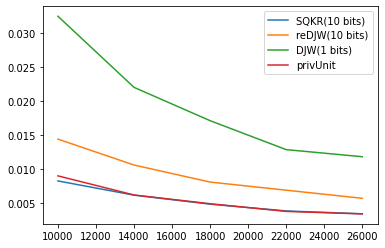

d = 200
eps = 5
--------------
n = 10000
Kashin mse: 0.020321
DJW mse: 0.033492
reDJW mse: 0.029903
priUnit mse: 0.014470
--------------
n = 14000
Kashin mse: 0.015205
DJW mse: 0.023014
reDJW mse: 0.020818
priUnit mse: 0.010771
--------------
n = 18000
Kashin mse: 0.011728
DJW mse: 0.018168
reDJW mse: 0.016549
priUnit mse: 0.008194
--------------
n = 22000
Kashin mse: 0.009794
DJW mse: 0.014556
reDJW mse: 0.013020
priUnit mse: 0.006797
--------------
n = 26000
Kashin mse: 0.008212
DJW mse: 0.011772
reDJW mse: 0.011161
priUnit mse: 0.005560
--------------
Kashin mse:
[0.02032105 0.0152047  0.01172827 0.00979422 0.00821235]
DJW mse:
[0.03349185 0.02301438 0.01816765 0.01455641 0.01177226]
reDJW mse:
[0.02990339 0.02081822 0.01654932 0.01301961 0.01116108]
privUnit mse:
[0.01447005 0.01077073 0.00819408 0.00679733 0.00556047]


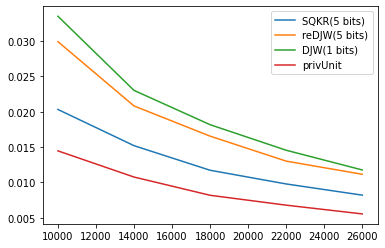

d = 200
eps = 1
--------------
n = 10000
Kashin mse: 0.333541
DJW mse: 0.153219
reDJW mse: 0.141565
priUnit mse: 0.142321
--------------
n = 14000
Kashin mse: 0.239695
DJW mse: 0.106280
reDJW mse: 0.107914
priUnit mse: 0.115441
--------------
n = 18000
Kashin mse: 0.187916
DJW mse: 0.079976
reDJW mse: 0.082975
priUnit mse: 0.087091
--------------
n = 22000
Kashin mse: 0.146414
DJW mse: 0.068500
reDJW mse: 0.068796
priUnit mse: 0.074576
--------------
n = 26000
Kashin mse: 0.127828
DJW mse: 0.057657
reDJW mse: 0.055452
priUnit mse: 0.062765
--------------
Kashin mse:
[0.33354126 0.2396952  0.18791579 0.14641418 0.12782768]
DJW mse:
[0.1532191  0.10628022 0.07997606 0.06850041 0.0576567 ]
reDJW mse:
[0.14156537 0.10791357 0.08297521 0.06879576 0.05545242]
privUnit mse:
[0.14232149 0.11544099 0.08709133 0.074576   0.06276471]


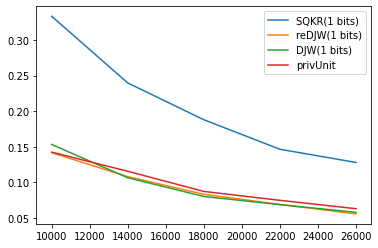

In [ ]:
if __name__ == "__main__":

	# set parameters
	num_itr = 11
	init_size = 10000
	step_size = 4000
	step_num = 5
	indices = [init_size + i*step_size for i in range(step_num)]


	for d in [200]:
		for eps in [10, 5, 1]:
			k_equiv = eps
			kashin_mse_list = np.zeros(step_num)
			DJW_mse_list = np.zeros(step_num) 
			reDJW_mse_list = np.zeros(step_num)			
			privUnit_mse_list = np.zeros(step_num) 

			print("d = %d" %d)
			print("eps = %d" %k_equiv)
			for step in range(step_num):
				n = init_size + step_size*step
				print("--------------") 
				print("n = %d" %n)
				for itr in range(num_itr):
					#print("itr = %d" %itr)
					# Generate a random tight frame satisfying UP
					N = 2**int(math.ceil(math.log(d, 2))+1)
					#U = (1/np.sqrt(N)*hadamard(N)@np.diag(2*np.random.binomial(1, 1/2*np.ones(N))-1))[:, 0:d] # random Hadamard (can be accelerated by FWHT)
					U = ortho_group.rvs(dim=N).T[:, 0:d]
					
          # Generate data matrix
					X = np.zeros((d, n))
					for j in range(int(n/2)):
						v_1 = np.concatenate([np.random.normal(10,1,int(d))])
						v_2 = np.concatenate([np.random.normal(1,1,int(d))])
						X[:,j] = v_1/np.linalg.norm(v_1)
						X[:,j+int(n/2)] = v_2/np.linalg.norm(v_2)

          # Kashin
					[q_quantize, q_sampling, q_perturb] = Kashin_encode(U, X, k_equiv, eps)
					X_hat = Kashin_decode(U, k_equiv, eps, q_perturb)
					mse = np.linalg.norm(np.mean(X, axis = 1).reshape(-1,1) - X_hat)**2
					kashin_mse_list[step] = kashin_mse_list[step] + mse*1/num_itr
					#print(mse)
					
					# DJW
					[X_perturb, B] = DJW(X, eps)
					X_hat = B*np.mean(np.array(X_perturb), axis = 1).reshape(-1,1)
					mse = np.linalg.norm(np.mean(X, axis = 1).reshape(-1,1) - X_hat)**2
					DJW_mse_list[step] = DJW_mse_list[step] + mse*1/num_itr
					#print(mse)
					
          # DJW_repeated
					X_hat = 0
					for i in range(int(eps)):
						[X_perturb, B] = DJW(X, 1)
						X_hat = X_hat + 1/int(eps)*B*np.mean(np.array(X_perturb), axis = 1).reshape(-1,1)
					mse = np.linalg.norm(np.mean(X, axis = 1).reshape(-1,1) - X_hat)**2
					reDJW_mse_list[step] = reDJW_mse_list[step] + mse*1/num_itr
					#print(mse)

          # privUnit
					p = math.exp(0.8*eps)/(1+math.exp(0.8*eps))
					gamma = find_best_gamma(X, 0.2*eps)
					[X_perturb, m] = privUnit(X, p, gamma)
					X_hat = m*np.mean(np.array(X_perturb), axis = 1).reshape(-1,1)
					mse = np.linalg.norm(np.mean(X, axis = 1).reshape(-1,1) - X_hat)**2
					privUnit_mse_list[step] = privUnit_mse_list[step] + mse*1/num_itr
					#print(mse)

				print("Kashin mse: %f" %kashin_mse_list[step])
				print("DJW mse: %f" %DJW_mse_list[step])
				print("reDJW mse: %f" %reDJW_mse_list[step])
				print("priUnit mse: %f" %privUnit_mse_list[step])        

			print("--------------") 
			print("Kashin mse:")
			print(kashin_mse_list)
			print("DJW mse:")
			print(DJW_mse_list)
			print("reDJW mse:")
			print(reDJW_mse_list)
			print("privUnit mse:")
			print(privUnit_mse_list)
   
			plt.plot(np.array(indices), kashin_mse_list, label = 'SQKR('+str(eps)+' bits)')
			plt.legend()
			plt.plot(np.array(indices), reDJW_mse_list, label = 'reDJW('+str(eps)+' bits)')
			plt.legend()
			plt.plot(np.array(indices), DJW_mse_list, label = 'DJW(1 bits)')
			plt.legend()
			plt.plot(np.array(indices), privUnit_mse_list, label = 'privUnit')
			plt.legend()
			plt.show()

			data = {
				'd' : d,
				'eps': eps,
				'k' : k_equiv,
				'k_equiv' : k_equiv,
				'kashin_mse' : kashin_mse_list,
				'DJW_mse' : DJW_mse_list,
				'reDJW_mse' : reDJW_mse_list,
        'privUnit_mse' : privUnit_mse_list,
				'indices' : indices
			}
			para = 'pU_reDJW_d_{}_eps_{}_k_{}_'.format(d, eps, k_equiv)
			if not os.path.exists('Data'):
				os.makedirs('Data')
			filename = 'Data/' + para + '.mat'
			io.savemat(filename, data)  